In [1]:
!pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=2b4eebfa9c1f59149e01ef491e9d3357c4f2da246b20a05381ee3185cc345d74
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\6c\e3\9b\0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark


In [13]:
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import isnan, when, col,count,lit, regexp_extract, mean, avg, split
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import pyspark

import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (13,6)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ModuleNotFoundError: No module named 'pyspark'

In [12]:
! pip install pyspark


In [3]:
# Create Spark Session
from pyspark.sql import SparkSession

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/27 21:48:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# File location and type
file_location = "C:/Users/bonfa/Downloads/train.csv"
# df = spark.read.csv(file_location, header=True, inferSchema=True)
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [5]:
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [6]:
df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [7]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

Columns overview


,Column Name,Data type
0,PassengerId,int
1,Survived,int
2,Pclass,int
3,Name,string
4,Sex,string
5,Age,double
6,SibSp,int
7,Parch,int
8,Ticket,string
9,Fare,double


In [8]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

Data frame describe (string and numeric columns only):


,summary,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,count,891,891,891,891,891,714,891,891,891,891,204,889
1,mean,446.0,0.3838383838383838,2.308641975308642,None,None,29.69911764705882,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,None,None
2,stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,None,None,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,None,None
3,min,1,0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
4,max,891,1,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


In [9]:
print(f'There are total {df.count()} row, Let print first 3 data rows:')
df.limit(3).toPandas()

There are total 891 row, Let print first 3 data rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [10]:
from pyspark.sql.functions import isnan, count, when, col
display(df.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in df.columns]))

DataFrame[PassengerId: bigint, Survived: bigint, Pclass: bigint, Name: bigint, Sex: bigint, Age: bigint, SibSp: bigint, Parch: bigint, Ticket: bigint, Fare: bigint, Cabin: bigint, Embarked: bigint]

In [11]:
df.groupBy("Survived").count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



In [12]:
df.groupBy("Sex","Survived").count().show()

+------+--------+-----+
|   Sex|Survived|count|
+------+--------+-----+
|  male|       0|  468|
|female|       1|  233|
|female|       0|   81|
|  male|       1|  109|
+------+--------+-----+



#### - **`Pclass`:**

In [13]:
df.groupBy("Pclass","Survived").count().show()

+------+--------+-----+
|Pclass|Survived|count|
+------+--------+-----+
|     1|       0|   80|
|     3|       1|  119|
|     1|       1|  136|
|     2|       1|   87|
|     2|       0|   97|
|     3|       0|  372|
+------+--------+-----+



#### - **`Age`:**

In [14]:
df_pd = df.toPandas()

[Text(0.5, 0, 'Age Groups'), Text(0, 0.5, 'Number  of  Travelers')]

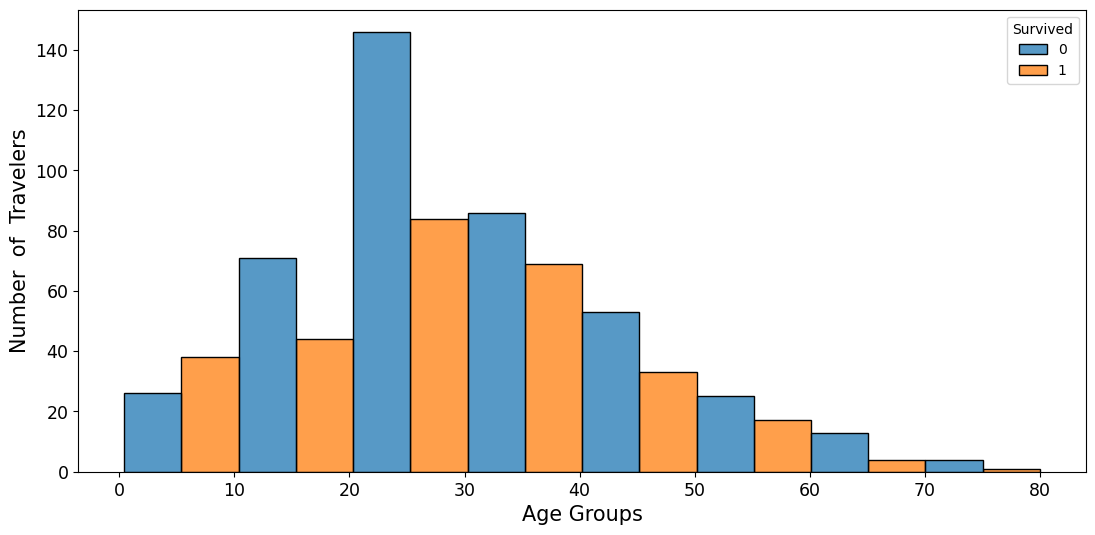

In [15]:
df_pd = df.toPandas()
plt.rcParams["axes.labelsize"] = 15
plt.tick_params(labelsize=12.5)
ax = sns.histplot(data=df_pd, x="Age", hue="Survived",  multiple="dodge", bins=8)
ax.set(xlabel='Age Groups',
       ylabel='Number  of  Travelers')

In [16]:
df.select('Age').distinct().count() #THIS IS THE NUMBER OF UNIQUE VALUES IN THE AGE COLUMN

89

#### - **`Embarked`:**<br>

In [17]:
df.groupBy("Embarked","Survived").count().show()

+--------+--------+-----+
|Embarked|Survived|count|
+--------+--------+-----+
|    null|       1|    2|
|       Q|       1|   30|
|       S|       0|  427|
|       S|       1|  217|
|       C|       1|   93|
|       Q|       0|   47|
|       C|       0|   75|
+--------+--------+-----+



#### - **`Fare`:**<br>

In [18]:
df.groupBy("Fare","Survived").count().show(5)

+-------+--------+-----+
|   Fare|Survived|count|
+-------+--------+-----+
|   28.5|       0|    1|
|56.4958|       1|    5|
|  24.15|       0|    7|
|  120.0|       1|    4|
|  15.85|       0|    2|
+-------+--------+-----+
only showing top 5 rows



In [19]:
df_pd.Fare.describe() #THIS IS THE STATISTICAL DESCRIPTION OF THE FARE COLUMN

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [20]:
df_pd['Fare_Class'] = pd.cut(df_pd['Fare'], bins=[0,7.91,14.45,31,512.33], labels=['Low','Mid_Low-Mid','Mid-Mid_High','High'])

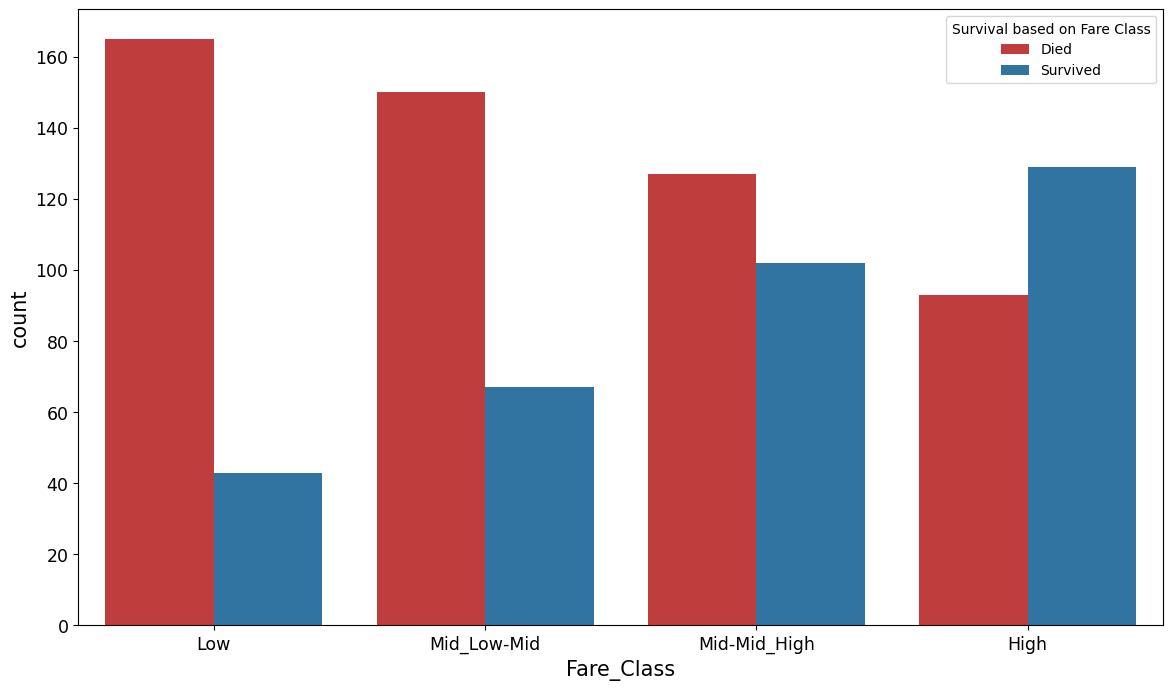

In [21]:
plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams["axes.labelsize"] = 15
plt.tick_params(labelsize=12.5)
ax_2 = sns.countplot(x = "Fare_Class", hue = "Survived", data = df_pd, palette=["C3", "C0"]).legend(labels = ["Died", "Survived"])
ax_2.set_title("Survival based on Fare Class")


#### - **`Ticket`:**<br>

In [22]:
df.groupBy("Ticket","Survived").count().show(5)

+--------+--------+-----+
|  Ticket|Survived|count|
+--------+--------+-----+
|  330958|       1|    1|
|  350404|       0|    1|
|    2693|       0|    1|
|  349912|       0|    1|
|CA. 2343|       0|    7|
+--------+--------+-----+
only showing top 5 rows



In [23]:
df.select('Ticket').distinct().count() #this is the number of unique values in the Ticket column

681

#### - **`Cabin`:**<br>

In [24]:
df.groupBy("Cabin", "Survived").count().show(5)

+-----+--------+-----+
|Cabin|Survived|count|
+-----+--------+-----+
|  C78|       0|    1|
|   F2|       0|    1|
|   A7|       0|    1|
|  D45|       1|    1|
|  C47|       1|    1|
+-----+--------+-----+
only showing top 5 rows



In [25]:
df.select('Cabin').distinct().count() #this is the number of unique values in the Cabin column

148

In [26]:
df_pyspark=df.drop('Cabin','Ticket','PassengerId')

In [27]:
df_pyspark.show(5)

+--------+------+--------------------+------+----+-----+-----+-------+--------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+--------------------+------+----+-----+-----+-------+--------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|
+--------+------+--------------------+------+----+-----+-----+-------+--------+
only showing top 5 rows



In [28]:
from pyspark.sql.functions import mean,col,split, regexp_extract, lit
 #extract the title from the name column
df_pyspark = df_pyspark.withColumn("Title",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))

In [29]:
df_pyspark.show(5)

+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked|Title|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|   Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|  Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S| Miss|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|  Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|   Mr|
+--------+------+--------------------+------+----+-----+-----+-------+--------+-----+
only showing top 5 rows



In [30]:
df_pyspark.select("Title").distinct().show()

+--------+
|   Title|
+--------+
|     Don|
|    Miss|
|Countess|
|     Col|
|     Rev|
|    Lady|
|  Master|
|     Mme|
|    Capt|
|      Mr|
|      Dr|
|     Mrs|
|     Sir|
|Jonkheer|
|    Mlle|
|   Major|
|      Ms|
+--------+



In [31]:
df_pyspark = df_pyspark.replace(['Capt','Col', 'Major', 'Jonkheer','Don','Sir','Dr','Rev','Countess','Mme','Mlle','Ms','Lady'],
               ['Officer','Officer','Officer','Royalty','Royalty', 'Royalty', 'Other','Other', 'Royalty', "Mrs", "Miss", 'Miss', "Royalty"])

In [32]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|
|       0|     3|    Moran, Mr. James|  male|null|    0|    0| 8.4583|       Q|    Mr|
|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|51.8625|       S|    Mr|
|       0|     3|Palsson, Master. ...|  male| 2.0|    3|    1| 21.075|       S|Master|
|       1|     3|Johnson, Mrs. Osc...|femal

In [33]:
print("Average age of a Miss travelling without Parents 'MissA'", 
      df_pyspark[(df_pyspark.Title=="Miss") & (df_pyspark.Parch==0)].agg(mean('Age').alias('mean')).collect())
print("Average age of a Miss travelling with Parents 'MissPar'", 
      df_pyspark[(df_pyspark.Title=="Miss") & (df_pyspark.Parch!=0)].agg(mean('Age').alias('mean')).collect())

Average age of a Miss travelling without Parents 'MissA' [Row(mean=27.68617021276596)]
Average age of a Miss travelling with Parents 'MissPar' [Row(mean=11.863636363636363)]


In [34]:
# Average age of a Miss travelling without Parents 'MissA' [Row(mean=21.773972602739725)]
df_pyspark = df_pyspark.withColumn("NewTitle",
                        when((df_pyspark.Title=="Miss") & (df_pyspark.Parch==0), 'MissA')
                       .when((df_pyspark.Title=="Miss") & (df_pyspark.Parch!=0), 'MissPar')
                       .otherwise(df_pyspark['Title']))
                      
    

In [35]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|NewTitle|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|      Mr|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|     Mrs|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|   MissA|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|     Mrs|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|      Mr|
|       0|     3|    Moran, Mr. James|  male|null|    0|    0| 8.4583|       Q|    Mr|      Mr|
|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|51.8625|       S|    Mr|      Mr|
|       0|     3|Palsson, Master. ...|  

In [36]:
my_list = df_pyspark.groupby(['NewTitle', 'Pclass']).avg(('Age')).collect()

In [37]:
spark.createDataFrame(my_list).show()

+--------+------+------------------+
|NewTitle|Pclass|          avg(Age)|
+--------+------+------------------+
|   MissA|     2|            30.375|
|     Mrs|     3|33.515151515151516|
|      Mr|     1| 41.58045977011494|
|   Other|     1|             43.75|
| MissPar|     3| 6.903846153846154|
| MissPar|     1|              21.0|
|   MissA|     1| 34.25806451612903|
|     Mrs|     1|              40.4|
|   Other|     2|              42.0|
|      Mr|     2| 32.76829268292683|
|  Master|     3| 5.350833333333334|
|   MissA|     3|21.697674418604652|
| Officer|     1|              56.6|
|      Mr|     3|28.724890829694324|
| Royalty|     1|              41.6|
|  Master|     2|2.2588888888888885|
|  Master|     1| 5.306666666666667|
| MissPar|     2|10.538461538461538|
|     Mrs|     2| 33.68292682926829|
+--------+------+------------------+



In [38]:
# Here we are imputing the missing values of the Age column with the average age of the passengers with the same title and class.

df_pyspark = df_pyspark.withColumn("AgeImputed",
                         when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 28.72)
                        .when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 32.77)
                        .when((df_pyspark.NewTitle=="Mr") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 41.58)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 33.5)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 33.68)
                        .when((df_pyspark.NewTitle=="Mrs") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 40.4)
                        .when((df_pyspark.NewTitle=="Other") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 42)
                        .when((df_pyspark.NewTitle=="Other") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 43.8)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 21.7)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 30.38)
                        .when((df_pyspark.NewTitle=="MissA") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 34.26)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 6.9)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 10.54)
                        .when((df_pyspark.NewTitle=="MissPar") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 21)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==3) & (df_pyspark.Age.isNull()), 5.35)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==2) & (df_pyspark.Age.isNull()), 2.26)
                        .when((df_pyspark.NewTitle=="Master") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 5.31)
                        .when((df_pyspark.NewTitle=="Officer|") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 56.6)
                        .when((df_pyspark.NewTitle=="Royalty|") & (df_pyspark.Pclass==1) & (df_pyspark.Age.isNull()), 41.6)
                        .otherwise(df_pyspark.Age))

In [39]:
df_pyspark = df_pyspark.na.fill({"Embarked" : 'S'})

In [40]:
df_pyspark.show(20)

+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+----------+
|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Embarked| Title|NewTitle|AgeImputed|
+--------+------+--------------------+------+----+-----+-----+-------+--------+------+--------+----------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25|       S|    Mr|      Mr|      22.0|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|       C|   Mrs|     Mrs|      38.0|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925|       S|  Miss|   MissA|      26.0|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1|       S|   Mrs|     Mrs|      35.0|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05|       S|    Mr|      Mr|      35.0|
|       0|     3|    Moran, Mr. James|  male|null|    0|    0| 8.4583|       Q|    Mr|      Mr|     28.72|
|       0|     1|McCarthy, Mr. Tim...

In [41]:
df_pyspark=df_pyspark.drop('Name','Age','Title')

In [42]:
df_pyspark.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in df_pyspark.columns]).show()

+--------+------+---+-----+-----+----+--------+--------+----------+
|Survived|Pclass|Sex|SibSp|Parch|Fare|Embarked|NewTitle|AgeImputed|
+--------+------+---+-----+-----+----+--------+--------+----------+
|       0|     0|  0|    0|    0|   0|       0|       0|         0|
+--------+------+---+-----+-----+----+--------+--------+----------+



In [43]:
df_pyspark.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- NewTitle: string (nullable = true)
 |-- AgeImputed: double (nullable = true)



In [44]:
stages=[]
cat=['Sex','Embarked','Pclass','NewTitle']

In [45]:
for catCol in cat:
    indexer = StringIndexer(inputCol=catCol, outputCol=catCol+'Index',stringOrderType='frequencyDesc')
    encoder=OneHotEncoder(inputCols=[indexer.getOutputCol()],outputCols=[catCol+'catVec'])
    stages+=[indexer,encoder]
    
stages

[StringIndexer_eeb686001ac6,
 OneHotEncoder_7738c1bc7568,
 StringIndexer_b455bdc12376,
 OneHotEncoder_1b69a77233ac,
 StringIndexer_18dde12a0548,
 OneHotEncoder_bdfd83844f1b,
 StringIndexer_f82381fc7994,
 OneHotEncoder_2784e2a573c7]

In [46]:
numeric=['Fare','SibSp','Parch','AgeImputed']

In [47]:
assembleInputs=[c+'catVec' for c in cat]+numeric
assembler=VectorAssembler(inputCols=assembleInputs,outputCol="features")
stages+=[assembler]

In [48]:
train_data, test_data = df_pyspark.randomSplit([0.8,0.2],seed=42) 

In [49]:
# pipeline
pipeline=Pipeline().setStages(stages)
pipelineModel=pipeline.fit(train_data)

In [50]:
train_pipe=pipelineModel.transform(train_data)
test_pipe=pipelineModel.transform(test_data)

In [51]:
train_pipe.head(1)

[Row(Survived=0, Pclass=1, Sex='female', SibSp=0, Parch=0, Fare=28.7125, Embarked='C', NewTitle='MissA', AgeImputed=50.0, SexIndex=1.0, SexcatVec=SparseVector(1, {}), EmbarkedIndex=1.0, EmbarkedcatVec=SparseVector(2, {1: 1.0}), PclassIndex=1.0, PclasscatVec=SparseVector(2, {1: 1.0}), NewTitleIndex=1.0, NewTitlecatVec=SparseVector(7, {1: 1.0}), features=SparseVector(16, {2: 1.0, 4: 1.0, 6: 1.0, 12: 28.7125, 15: 50.0}))]

In [52]:
from pyspark.ml.classification import RandomForestClassifier

In [53]:
# Random Forest Classification
rf = RandomForestClassifier(labelCol = 'Survived', predictionCol='prediction', seed=42)
rfmodel = rf.fit(train_pipe)

In [54]:
pred_results_rf = rfmodel.transform(test_pipe)

In [55]:
 # For the Training Set
summary=rfmodel.summary
summary.accuracy

0.839142091152815

In [56]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Survived')

rfevaluator=evaluator.evaluate(pred_results_rf)
# equal to:
auroc = evaluator.evaluate(pred_results_rf, {evaluator.metricName: "areaUnderROC"})

aupr= evaluator.evaluate(pred_results_rf, {evaluator.metricName: "areaUnderPR"})
print('Area under ROC curve: ',auroc)
print('Area under PR curve: ',aupr)

Area under ROC curve:  0.8982240437158471
Area under PR curve:  0.891833388917776


In [57]:
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 4, 5])
               .addGrid(rf.numTrees, [5, 10, 20, 100])
             .build())

In [58]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluatorRF=BinaryClassificationEvaluator(labelCol='Survived')

cv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluatorRF,
                      numFolds = 5)

rfcv=cv.fit(train_pipe)

In [59]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
predictions=rfcv.bestModel.transform(test_pipe)
evaluatorRF.evaluate(predictions)

0.8963700234192037

In [60]:
# As, by default, the metric name of the BinaryClassificationEvaluator is areaUnderROC the first value will be equal to the cell above
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr= evaluatorRF.evaluate(predictions, {evaluatorRF.metricName: "areaUnderPR"})
print('Area under ROC curve: ',auroc)
print('Area under PR curve: ',aupr)

Area under ROC curve:  0.8963700234192037
Area under PR curve:  0.8920463126057557


In [61]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [62]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
rf_accuracy = multi_evaluator.evaluate(predictions)
print("Accuracy of RandomForestClassifier is = ", (rf_accuracy))

Accuracy of RandomForestClassifier is =  0.8413793103448276


In [63]:
from sklearn.metrics import classification_report

In [64]:
y_true = predictions.select(['Survived']).collect()
y_pred = predictions.select(['prediction']).collect()

In [65]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        84
           1       0.85      0.75      0.80        61

    accuracy                           0.84       145
   macro avg       0.84      0.83      0.83       145
weighted avg       0.84      0.84      0.84       145

